# Clustering for ECMA Final Project

In [44]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
# Setting path for the data in my local library - feel free to config as necessary

path = './ML_final_project/ECMA_Final_Project'

In [216]:
# Getting the census data

data = pd.read_csv(path+'/Data/Census_C/census_data.csv')

In [217]:
# Selecting only the columns of the census data that are actual continuous variables
# rather than categorical values / indices like county name or date

census_vars = data.iloc[:,2:].fillna(0)

### Visualization

In [218]:
# Using t-SNE to visualize the high-dimensional data since it's impossible to visualize
# the counties along all of the features simultaneously

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(test)
X_embedded = pd.DataFrame(X_embedded)

In [41]:
# Checking what the t-SNE gives us - namely, a 3200 x 2 DataFrame that enables us
# to plot it onto a scatterplot

X_embedded

,0,1
0,-3.034029,-23.021559
1,26.399822,52.391087
2,-22.132315,23.366959
3,-18.529421,31.294134
4,-15.329369,-5.802651
...,...,...
3216,-41.137295,-16.591831
3217,-39.412388,-17.524845
3218,37.441860,31.649908
3219,15.987309,21.524673


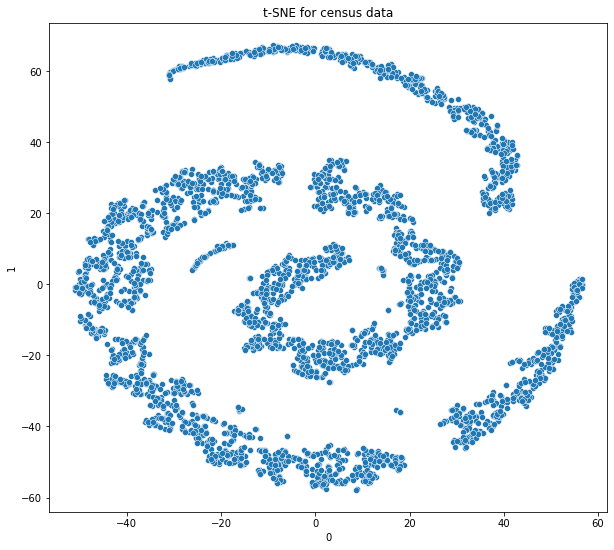

In [52]:
# Plotting the t-SNE for this to help figure out how we might be able to cluster the counties
# Reference: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

plt.figure(figsize=(10,9))
sns.scatterplot(x=0, y=1, data=X_embedded)
plt.title('t-SNE for census data')
plt.show()

### PCA

I'm using PCA here because trying to run these types of clustering algorithms over so many covariates is ineffective and likely will be subject to too much noise. I want to just isolate the really core signals and leave the rest out.

In [126]:
# Importing the PCA package
from sklearn.decomposition import PCA

# Fitting the PCA and specifying that we only want the first two principal components.
# Then saving the actual principal components over the 3220 counties in a DataFrame
pca = PCA(n_components=2).fit(census_vars.T)
pca_res = pd.DataFrame(pca.components_).T
pca_res

,0,1
0,-0.000009,-0.000029
1,-0.000036,-0.000116
2,-0.000004,-0.000011
3,-0.000003,-0.000011
4,-0.000010,-0.000033
...,...,...
3216,-0.000002,-0.000006
3217,-0.000002,-0.000006
3218,-0.000019,-0.000061
3219,-0.000005,-0.000016


In [127]:
# Checking how much of the variance in census data on a county level
# can be explained by our PCA variance ratio

pca.explained_variance_ratio_

array([0.90589598, 0.08015176])

__Holy moly !__ Lots of variance explained by literally two principal components. Gonna fit the clustering algorithms on that instead, then.

### K-Means

I spent a lot of time looking at different clustering algorithms (Spectral Clustering, DBSCAN, Optics, etc). However, none of their use cases really apply very well to a high-dimensional feature space where we're trying to capture at least somewhat similar size clusters. The issue with these other clustering algorithms is that, when you run them, they either (i) don't handle many clusters well and will assign the first one with 2,500 counties and then spread the other 800 across 300 different clusters, or (ii) aren't suitable for having a large number of clusters in the first place. As such, I think we're best off by using this type of clustering mechanism.

However, it's important to note that I use the init='random' parameter when calling the KMeans class. This is because, otherwise, sklearn will try to choose a starting point so that we get the fastest possible rate of convergence. However, that's not something that we're interested in. The major issue with this is that we don't get consistent answers to our clusters. There's so many local minimums in the objective function that we're always going to get slightly different answers when this code is called. I haven't been able to come up with a great solution, but if anybody has any bright ideas definitely shout them out. The most robust thing that I could come up with is to run this multiple times and come up with a weighted adjacency matrix where the "connectivity" of the points is determined by how often they appear in the same cluster. Then we could run spectral clustering using that, but that type of clustering algorithm isn't really effective when trying to calculate a large number of clusters (not the least bit because it has O(n^3) complexity).

Also, it's wildly unclear how many clusters we should choose ! Just another thing to consider.

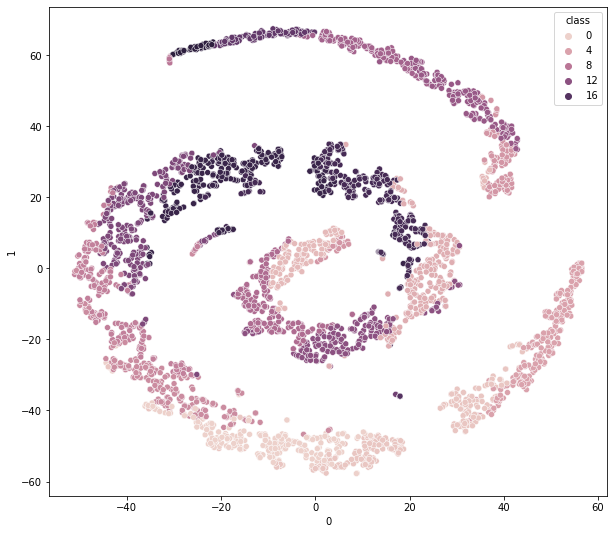

In [213]:
from sklearn.cluster import KMeans

# Calling and fitting the model to the PCA components
clustering = KMeans(n_clusters=20, init='random').fit(pca_res)

# Building an adjusted X matrix where we add the labels resulting from the
# K-means algorithm as an additional column. We also rename the columns so that
# we can accurately keep track of them.
X_adj = pd.concat([X_embedded, pd.DataFrame(clustering.labels_)], axis=1)
X_adj.columns = [0,1,'class']

# Using a scatterplot to plot the t-SNE with hue determined by the class
plt.figure(figsize=(10,9))
sns.scatterplot(x=0, y=1, hue='class', data=X_adj)
plt.show()

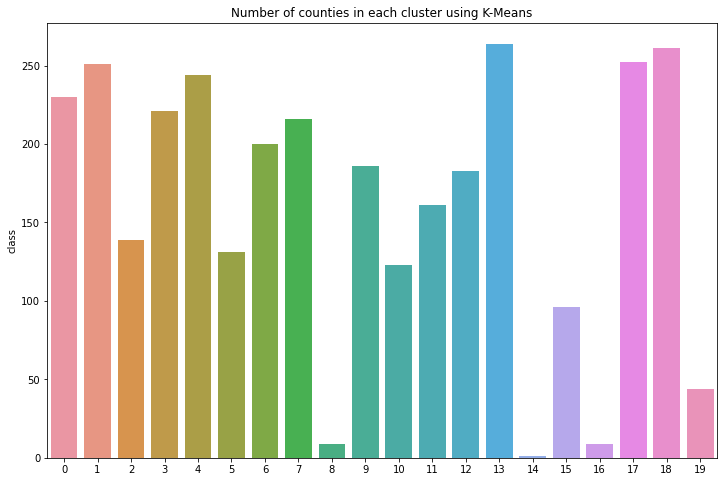

In [214]:
plt.figure(figsize=(12,8))
sns.barplot(x=np.arange(20), y=X_adj['class'].value_counts().sort_index())
plt.title('Number of counties in each cluster using K-Means')
plt.show()